# Rating Prediction Model Based on Review Text

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
from torch.utils.data import ConcatDataset,Subset,DataLoader,TensorDataset, random_split
import torch.nn.functional as F
from gensim.models import word2vec, Word2Vec
import argparse

import re
import string
#from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error, confusion_matrix,r2_score,accuracy_score

import io
import os
import time
import datetime
 
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10271\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10271\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Importing and Processing

In [2]:
import gzip
import json
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
df=getDF("Luxury_Beauty_5.json.gz")

class Dataprocess(Dataset):
    def __init__(self, path):
        #self.mode = mode
        data=path
        target =list( data["overall"])
        data = list(data["unixReviewTime"])
            
        self.data = torch.FloatTensor(data)
        self.target = torch.FloatTensor(target)


    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)

In [3]:
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4.0,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,1504396800,NaN,NaN
34274,4.0,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,1504396800,NaN,NaN
34275,1.0,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,Did nothing,One Star,1503619200,NaN,NaN
34276,5.0,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,I love the Oribe bright blonde radiance spray....,No more brass!,1499472000,NaN,NaN


In [4]:
#Convert to indicidual words and removing stop words
df['reviewText'] = df['reviewText'].astype(str).str.lower()

#split the review text into individual words
def identify_tokens(row):
    review = row['reviewText']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['words'] = df.apply(identify_tokens, axis=1)

stops = set(stopwords.words("english"))                  
def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['meaningful_words'] = df.apply(remove_stops, axis=1)

In [5]:
#Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).
def remove_negation(row):
    my_list = row['meaningful_words']
    negation_words = [re.sub("n\'t | no | never |not ", ' not_',i) for i in my_list]
    return (negation_words)
df['meaningful_words'] = df.apply(remove_negation, axis=1)

In [6]:
#Stem all words using Porter 1979
stemming = PorterStemmer()
def stem_list(row):
    my_list = row['meaningful_words']
    stem_list = [stemming.stem(word) for word in my_list]
    return (stem_list)

df['stem_meaningful'] = df.apply(stem_list, axis=1)

In [7]:
#Drop useless columns
df=df.drop(["vote","image","unixReviewTime"], axis=1)
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,words,meaningful_words,stem_meaningful
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,this handcream has a beautiful fragrance. it d...,Beautiful Fragrance,"[this, handcream, has, a, beautiful, fragrance...","[handcream, beautiful, fragrance, doesnt, stay...","[handcream, beauti, fragranc, doesnt, stay, pr..."
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,"[wonderful, hand, lotion, for, seriously, dry,...","[wonderful, hand, lotion, seriously, dry, skin...","[wonder, hand, lotion, serious, dri, skin, sta..."
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"best hand cream around. silky, thick, soaks i...",Best hand cream around,"[best, hand, cream, around, silky, thick, soak...","[best, hand, cream, around, silky, thick, soak...","[best, hand, cream, around, silki, thick, soak..."
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,thanks!!,Five Stars,[thanks],[thanks],[thank]
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,great hand lotion. soaks right in and leaves ...,Great hand lotion!,"[great, hand, lotion, soaks, right, in, and, l...","[great, hand, lotion, soaks, right, leaves, sk...","[great, hand, lotion, soak, right, leav, skin,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4.0,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,i like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,"[i, like, to, use, moisturizers, and, sunscree...","[like, use, moisturizers, sunscreens, tint, pr...","[like, use, moistur, sunscreen, tint, product,..."
34274,4.0,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,i wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,"[i, would, be, able, to, afford, this, if, not...","[would, able, afford, asked, review, deducted,...","[would, abl, afford, ask, review, deduct, star..."
34275,1.0,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,did nothing,One Star,"[did, nothing]",[nothing],[noth]
34276,5.0,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,i love the oribe bright blonde radiance spray....,No more brass!,"[i, love, the, oribe, bright, blonde, radiance...","[love, oribe, bright, blonde, radiance, spray,...","[love, orib, bright, blond, radianc, spray, us..."


In [8]:
def train_word2vec(x):
    model = word2vec.Word2Vec(x, vector_size=500, window=5, min_count=5, workers=12)
    return model
model = train_word2vec(df["words"])

### Word Embedding

In [9]:
class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # load word to vector model
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # add word into embedding
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError

        for i, word in enumerate(self.embedding.wv.key_to_index):
            print('get words #{}'.format(i+1), end='\r')
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding.wv[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # turn labels into tensors
        y = [int(label) for label in y]
        return torch.FloatTensor(y)

In [10]:
class Datasets(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)


### Turn y into One-Hot Vector

In [11]:
def rating_encode(rating):
    arr = [0,0,0,0,0]
    arr[int(rating)-1] = 1
    return arr

### Load Data into Batches

In [12]:
x=df["words"]
y=df["overall"].astype(int).tolist()
sen_len=200
batch_size=128
w2v_path = os.path.join(path_prefix, 'w2v_all.model')

preprocess_x = Preprocess(x, sen_len, w2v_path=w2v_path)
embedding = preprocess_x.make_embedding(load=True)
x = preprocess_x.sentence_word2idx()

encoded_ratings = [rating_encode(i) for i in y]
y=torch.FloatTensor(encoded_ratings)


X_train, X_val, y_train, y_val = x[:30000], x[30000:], y[:30000], y[30000:]
train_dataset = Datasets(X=X_train, y=y_train)
val_dataset = Datasets(X=X_val, y=y_val)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
print("finish")

Get embedding ...
loading word to vec model ...
get words #23000
total words: 23002
finishce count #34278


### LSTM Model

In [13]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers=1,tagset_size=5,dropout=0.4,fix_embedding=True):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        self.embedding_dim = embedding.size(1)
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.num_layers = num_layers
        self.dropout = dropout
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim) 

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, word):
        embeds = self.embedding(word)
#        print(embeds.size()) #128,200,500
        lstm_out, _ = self.lstm(embeds.view(len(word), sen_len, -1))
#        print(lstm_out.size())#128,200,300
#         tag_space = self.hidden2tag(lstm_out.view(len(word),sen_len, -1)) #300->5
#         print(tag_space.size())
        y = self.hidden2tag(lstm_out[:,-1])
#        print(y.size()) #128,5
        tag_scores = F.log_softmax(y, dim=1)
        return tag_scores

### Training Process

In [18]:
model = LSTMTagger(embedding, embedding_dim=500, hidden_dim=300)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4, verbose=True)
epochs = 10
model_dir = path_prefix
criterion = nn.CrossEntropyLoss()
tqdm(range(100),ncols=80)
max_acc=0

for epoch in range(epochs):
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        
        words, labels = batch
        logits = model(words.to(device))
        loss = criterion(logits, labels.to(device))
        

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc=(logits.argmax(dim=-1)==labels.to(device).argmax(dim=-1)).float().mean()
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
   
        words, labels = batch


        with torch.no_grad():
          logits = model(words.to(device))
        
        
        loss = criterion(logits, labels.to(device))
        acc=(logits.argmax(dim=-1)==labels.to(device).argmax(dim=-1)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        torch.cuda.empty_cache()

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    scheduler.step(valid_acc)
    ### save best model
    if valid_acc > max_acc:
        # Save model if your model improved
        max_acc = valid_acc
        print('Saving model (epoch = {:4d}, acc = {:.5f})'.format(epoch + 1, max_acc))
        torch.save(model.state_dict(),f"best_model.ckpt")

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:37<00:00,  6.32it/s]


[ Train | 001/010 ] loss = 1.13735, acc = 0.60604


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.31it/s]


Saving model (epoch =    1, acc = 0.43707)
[ Valid | 001/010 ] loss = 1.30081, acc = 0.43707


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:37<00:00,  6.31it/s]


[ Train | 002/010 ] loss = 1.12748, acc = 0.61005


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.45it/s]


[ Valid | 002/010 ] loss = 1.36873, acc = 0.43616


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:34<00:00,  6.87it/s]


[ Train | 003/010 ] loss = 1.12230, acc = 0.61025


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.27it/s]


[ Valid | 003/010 ] loss = 1.36265, acc = 0.43524


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:33<00:00,  6.97it/s]


[ Train | 004/010 ] loss = 1.12256, acc = 0.61088


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.23it/s]


[ Valid | 004/010 ] loss = 1.47171, acc = 0.43593


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:32<00:00,  7.27it/s]


[ Train | 005/010 ] loss = 1.12008, acc = 0.61025


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.66it/s]


Saving model (epoch =    5, acc = 0.43791)
[ Valid | 005/010 ] loss = 1.47318, acc = 0.43791


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:34<00:00,  6.82it/s]


[ Train | 006/010 ] loss = 1.12318, acc = 0.61026


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.75it/s]


[ Valid | 006/010 ] loss = 1.46449, acc = 0.43616


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:34<00:00,  6.75it/s]


[ Train | 007/010 ] loss = 1.11560, acc = 0.61147


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.61it/s]


Saving model (epoch =    7, acc = 0.43868)
[ Valid | 007/010 ] loss = 1.31168, acc = 0.43868


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:35<00:00,  6.61it/s]


[ Train | 008/010 ] loss = 1.12014, acc = 0.61156


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.81it/s]


Saving model (epoch =    8, acc = 0.43952)
[ Valid | 008/010 ] loss = 1.31833, acc = 0.43952


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:35<00:00,  6.64it/s]


[ Train | 009/010 ] loss = 1.11618, acc = 0.61242


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.54it/s]


[ Valid | 009/010 ] loss = 1.31728, acc = 0.43653


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:35<00:00,  6.68it/s]


[ Train | 010/010 ] loss = 1.11238, acc = 0.61275


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.92it/s]

[ Valid | 010/010 ] loss = 1.31640, acc = 0.43891


### BERT Model and Prepare the Data

In [20]:
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size=32
encoded_ratings = [rating_encode(i) for i in df["overall"]]
y=torch.FloatTensor(encoded_ratings)

input_ids = []
attention_masks = []
for sent in df["reviewText"].tolist():
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # input text
                        add_special_tokens = True, # add '[CLS]' 和 '[SEP]'
                        max_length = 64,           # filling & cut to same length
                        pad_to_max_length = True,
                        return_attention_mask = True,   # return attn. masks.
                        return_tensors = 'pt',     # return pytorch tensors formats
                   )
    
    # Adds the encoded text to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # Add the attention mask of the text to the attention_masks list as well
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


dataset = TensorDataset(input_ids, attention_masks, y)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### BERT Training

In [25]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return accuracy_score(labels_flat,pred_flat)

torch.cuda.empty_cache()

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format it as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4, verbose=True)
epochs = 5
model_dir = path_prefix
criterion = nn.CrossEntropyLoss()
training_stats = []

# Count the entire training time
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Count the training time of a single epoch
    t0 = time.time()

    # Reset the total training loss per epoch
    total_train_loss = 0

    # Set the model to training mode. This does not mean calling the training interface
    # dropout、batchnorm The layer behaves differently in training and test mode
    model.train()

    # Training set small batch iteration
    for step, batch in enumerate(train_loader):

        # Every 40 iterations, the progress information is printed
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Prepare the input data and copy it to the gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # You need to clear the gradient to zero before each gradient calculation, because pytorch gradients are cumulative
        model.zero_grad()        

        # Forward propagation
        # This function will return different values depending on the parameters. In this case, loss and logits -- the predicted result of the model -- are returned
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask)
        logits = outputs[0]
        loss=criterion(logits,b_labels)

#        loss = criterion(logits.view(-1, 5), b_labels.view(-1))
        # Cumulate loss
        total_train_loss += loss.item()

        # Back propagation
        loss.backward()

        # Gradient cutting to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameter
        optimizer.step()

        # Updating learning rate
        #scheduler.step()

    # Mean training error
    avg_train_loss = total_train_loss / len(train_loader)            
    
    # Training duration of a single epoch
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After completing an epoch training session, verify the performance of the model

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Set the model to evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:
        
        # Load the input data into the gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # There is no need to update parameters and calculate gradients during evaluation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask)
        logits = outputs[0]
        loss=criterion(logits,b_labels)

            
        # Cumulate loss
        total_eval_loss += loss.item()

        # Load the prediction and labels into the cpu to calculate
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate Accuracy
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Print the accuracy for this epoch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.5f}".format(avg_val_accuracy))

    # Count the epoch loss of this time
    avg_val_loss = total_eval_loss / len(val_loader)
    
    # Count the duration of the evaluation
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all the statistics about the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    965.    Elapsed: 0:00:10.
  Batch    80  of    965.    Elapsed: 0:00:20.
  Batch   120  of    965.    Elapsed: 0:00:30.
  Batch   160  of    965.    Elapsed: 0:00:39.
  Batch   200  of    965.    Elapsed: 0:00:49.
  Batch   240  of    965.    Elapsed: 0:00:59.
  Batch   280  of    965.    Elapsed: 0:01:09.
  Batch   320  of    965.    Elapsed: 0:01:19.
  Batch   360  of    965.    Elapsed: 0:01:29.
  Batch   400  of    965.    Elapsed: 0:01:39.
  Batch   440  of    965.    Elapsed: 0:01:49.
  Batch   480  of    965.    Elapsed: 0:01:59.
  Batch   520  of    965.    Elapsed: 0:02:08.
  Batch   560  of    965.    Elapsed: 0:02:18.
  Batch   600  of    965.    Elapsed: 0:02:28.
  Batch   640  of    965.    Elapsed: 0:02:38.
  Batch   680  of    965.    Elapsed: 0:02:48.
  Batch   720  of    965.    Elapsed: 0:02:58.
  Batch   760  of    965.    Elapsed: 0:03:08.
  Batch   800  of    965.    Elapsed: 0:03:18.
  Batch   840  of

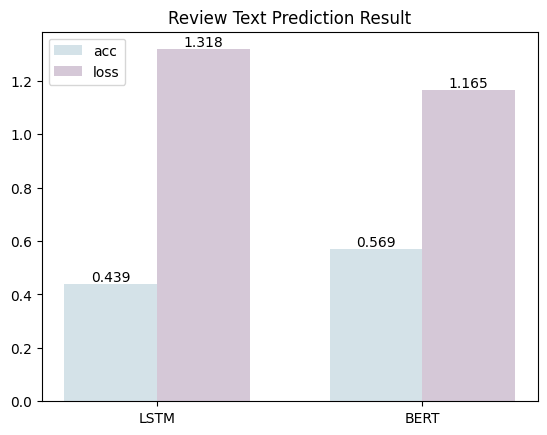

In [37]:
import matplotlib.pyplot as plt
acc=[0.43868, 0.56858]
loss=[1.31833, 1.16486]
x=["LSTM", "BERT"]
index = np.arange(2)
bar_width = 0.35
plt.bar(index, acc, alpha=0.9, width = bar_width, label="acc", color="#d0dfe6")
plt.bar(index+bar_width, loss, alpha=0.9, width = bar_width, label="loss", color="#d1c2d3")

for a,b in zip(index,acc):   
    plt.text(a,b,'%.3f'%b,ha='center',va='bottom',fontsize=10);
for a,b in zip(index+bar_width,loss):
    plt.text(a,b,'%.3f'%b,ha='center',va='bottom',fontsize=10);

plt.xticks(index+bar_width/2, x)
plt.title('Review Text Prediction Result')
plt.legend(loc="upper left")

### encode labels into binary targets, but got worse results

In [12]:
# from transformers import BertTokenizer, BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# batch_size=32

def rating_encode(i):
    if i>3.5:
        return 1
    else:
        return 0
encoded_ratings = [rating_encode(i) for i in df["overall"]]
y=torch.LongTensor(encoded_ratings)

input_ids = []
attention_masks = []
for sent in df["reviewText"].tolist():
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # input text
                        add_special_tokens = True, # add '[CLS]' 和 '[SEP]'
                        max_length = 64,           # filling & cut to same length
                        pad_to_max_length = True,
                        return_attention_mask = True,   # return attn. masks.
                        return_tensors = 'pt',     # return pytorch tensors formats
                   )
    
    # Adds the encoded text to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # Add the attention mask of the text to the attention_masks list as well
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


dataset = TensorDataset(input_ids, attention_masks, y)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)


In [14]:
# def flat_accuracy(preds, labels):
# #     pred_flat = np.argmax(preds, axis=1).flatten()
# #     labels_flat = np.argmax(labels, axis=1).flatten()
#     preds_flat=[]
#     for i in preds:
#         if i>0.6:
#             preds_flat.append(1)
#         else:
#             preds_flat.append(0)
#     return accuracy_score(labels,pred_flat)

torch.cuda.empty_cache()

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format it as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4, verbose=True)
epochs = 5
model_dir = path_prefix
criterion = nn.CrossEntropyLoss()
training_stats = []

# Count the entire training time
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Count the training time of a single epoch
    t0 = time.time()

    # Reset the total training loss per epoch
    total_train_loss = 0

    # Set the model to training mode. This does not mean calling the training interface
    # dropout、batchnorm The layer behaves differently in training and test mode
    model.train()

    # Training set small batch iteration
    for step, batch in enumerate(train_loader):

        # Every 40 iterations, the progress information is printed
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Prepare the input data and copy it to the gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # You need to clear the gradient to zero before each gradient calculation, because pytorch gradients are cumulative
        model.zero_grad()        

        # Forward propagation
        # This function will return different values depending on the parameters. In this case, loss and logits -- the predicted result of the model -- are returned
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask)
        logits = outputs[0]
        loss=criterion(logits,b_labels)

#        loss = criterion(logits.view(-1, 5), b_labels.view(-1))
        # Cumulate loss
        total_train_loss += loss.item()

        # Back propagation
        loss.backward()

        # Gradient cutting to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameter
        optimizer.step()

        # Updating learning rate
        #scheduler.step()

    # Mean training error
    avg_train_loss = total_train_loss / len(train_loader)            
    
    # Training duration of a single epoch
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After completing an epoch training session, verify the performance of the model

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Set the model to evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:
        
        # Load the input data into the gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # There is no need to update parameters and calculate gradients during evaluation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask)
        logits = outputs[0]
        loss=criterion(logits,b_labels)

            
        # Cumulate loss
        total_eval_loss += loss.item()

        # Load the prediction and labels into the cpu to calculate
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate Accuracy
        #total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_accuracy += (logits.argmax(1) == label_ids).sum()
        

    # Print the accuracy for this epoch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.5f}".format(avg_val_accuracy))

    # Count the epoch loss of this time
    avg_val_loss = total_eval_loss / len(val_loader)
    
    # Count the duration of the evaluation
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all the statistics about the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    965.    Elapsed: 0:00:11.
  Batch    80  of    965.    Elapsed: 0:00:22.
  Batch   120  of    965.    Elapsed: 0:00:33.
  Batch   160  of    965.    Elapsed: 0:00:44.
  Batch   200  of    965.    Elapsed: 0:00:55.
  Batch   240  of    965.    Elapsed: 0:01:06.
  Batch   280  of    965.    Elapsed: 0:01:16.
  Batch   320  of    965.    Elapsed: 0:01:27.
  Batch   360  of    965.    Elapsed: 0:01:38.
  Batch   400  of    965.    Elapsed: 0:01:48.
  Batch   440  of    965.    Elapsed: 0:01:59.
  Batch   480  of    965.    Elapsed: 0:02:10.
  Batch   520  of    965.    Elapsed: 0:02:21.
  Batch   560  of    965.    Elapsed: 0:02:31.
  Batch   600  of    965.    Elapsed: 0:02:43.
  Batch   640  of    965.    Elapsed: 0:02:54.
  Batch   680  of    965.    Elapsed: 0:03:05.
  Batch   720  of    965.    Elapsed: 0:03:17.
  Batch   760  of    965.    Elapsed: 0:03:29.
  Batch   800  of    965.    Elapsed: 0:03:41.
  Batch   840  of

KeyboardInterrupt: 